# Astroquery
Astroquery is package that provides a set of tools to query astronomical databases. In this tutorial, we will focus on the CADC package of astroquery, which queries data provided by the Canadian Astronomical Data Centre (http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca).

- https://github.com/astropy/astroquery

Resources:

- http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/doc/tap/
- https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/search/
- https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/
- http://www.canfar.net/storage/list/CADC

METHODS
- [ ]  get_table
- [ ]  get_tables
- [ ]  list_async_jobs
- [ ]  load_async_job
- [ ]  login
- [ ]  logout
- [ ]  query_async
- [ ]  run_query
- [ ]  save_results

FUNCTIONS
- [ ]  get_data_urls
- [ ]  list_jobs
- [ ]  load_job
- [ ]  query
- [ ]  query_name
- [ ]  query_name_async
- [ ]  query_region
- [ ]  query_region_async

# Tutorial
This tutorial will go through some of the basic functionalities of the CADC astroquery package. The CADC module can be installed using the command:

`pip install --pre astroquery`

(The `--pre` tag installs the pre-release version - which we need because the CADC package is not in the latest release.) More information about astroquery can be found at the github repository https://github.com/astropy/astroquery.

Now, onto the tutorial. The first step is to import the CADC module from astroquery.

In [12]:
from astroquery.cadc import Cadc
cadc = Cadc()


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


## Querying
The CADC astroquery package queries the CADC metadata and returns the results as an astropy table. 

There are three ways to query data: query by region, query by name, and using TAP access. The first two are more basic, while the latter query method involves some understanding of query languages. TAP stands for transfer access protocol (http://www.ivoa.net/documents/TAP/), and uses Astronomical Data Query Language (ADQL) to make queries.
    
There are two modes to query data: synchronous and asynchronous. 
    * Synchronous queries generate a response to a request as soon as it is received by the server. These queries have a limit of 2000 rows, so it is best when retrieving a small amout of data. Also, the results of synchronous queries are not stored server side. 
    * Asynchronous queries, on the other hand, start a job to execute the request, so there is no risk of time outs. The response to the request is a link to the job where its status can be viewed. The results are stored server-side, so once the job status is complete, the results can be downloaded.


### Query by region
One of the basic ways to access CADC data is by region. We can input the coordinates (and optionally, the radius and collection source) then the query will return observations that intersect that position/area taken from the collection source. The function accepts strings and SkyCoord objects as coordinates.


In [21]:
from astropy.coordinates import SkyCoord
from astropy import units as u

c = SkyCoord(ra=127.5, dec=4.3, frame='icrs', unit='deg')

# PROBLEM: query_region does not accept `astropy.units.Quantity` as in the docs.
result = cadc.query_region(c, radius=0.5, collection='HST') # HST short for Hubble Space Telescope
print(len(result))

75


In [22]:
result = cadc.query_region('08h45m07.5s +54d18m00s')
print(len(result))

663


### Query by object
Lets say we want to get data about the Andromeda Galaxy. It is also know as Messier 31, and therefore has identifier `M31`. We would use the `query_name` function to retreive data that contains 'M31' in an observation's `target_name`.

In [32]:
result = cadc.query_name('M31')
print("Number of results: {}".format(len(result)))
print("Number of columns: {}".format(len(result.columns)))

Number of results: 2000
Number of columns: 109


That is a huge number of columns to show. Let's print out the names and select a few that we want to display.

In [25]:
# result.info
#[print(col.info) for col in result.columns.values()]; 
[print(colname) for colname in result.colnames];

caomObservationURI
sequenceNumber
proposal_keywords
target_standard
target_redshift
target_moving
target_keywords
targetPosition_equinox
targetPosition_coordinates_cval1
targetPosition_coordinates_cval2
telescope_geoLocationX
telescope_geoLocationY
telescope_geoLocationZ
telescope_keywords
instrument_keywords
environment_seeing
environment_humidity
environment_elevation
environment_tau
environment_wavelengthTau
environment_ambientTemp
environment_photometric
members
typeCode
metaChecksum
obsID
accMetaChecksum
collection
observationID
algorithm_name
type
intent
metaRelease
proposal_id
proposal_pi
proposal_project
proposal_title
target_name
target_type
targetPosition_coordsys
telescope_name
requirements_flag
instrument_name
lastModified
maxLastModified
caomPlaneURI
caomPublisherID
calibrationLevel
provenance_keywords
provenance_inputs
metrics_sourceNumberDensity
metrics_background
metrics_backgroundStddev
metrics_fluxDensityLimit
metrics_magLimit
position_bounds
position_bounds_samples
p

Alright, lets look at `caomObservationURI`, `typeCode`, `type`, `intent`, `target_name`, `telescope_name`, `instrument_name`, and `lastModified`. We can grab information about the columns using the `info` property.

In [33]:
result['caomObservationURI', 'typeCode', 'type', 'intent', 'target_name', 
       'telescope_name', 'instrument_name', 'lastModified'].info


<Table masked=True length=2000>
       name         dtype                                      description                                    
------------------ ------- -----------------------------------------------------------------------------------
caomObservationURI  object                                                     unique URI for this observation
          typeCode  bytes1 single character code to denote type: S(impleObservation) or C(ompositeOvservation)
              type bytes32                                   type of data collected (e.g. FITS OBSTYPE header)
            intent bytes32                             intended purpose of data (one of: science, calibration)
       target_name bytes32                                                             name of intended target
    telescope_name bytes32                                       name of telescope used to acquire observation
   instrument_name bytes32                                      name of instrume

We can also print out the results in a nice table using `show_in_notebook`.

In [34]:
columns_to_print = ['caomObservationURI', 'typeCode', 'type', 'intent', 'target_name', 
       'telescope_name', 'instrument_name', 'lastModified']
result[columns_to_print].show_in_notebook()


idx,caomObservationURI,typeCode,type,intent,target_name,telescope_name,instrument_name,lastModified
0,caom:HST/ibft16r8q,S,IMAGING,science,M31-B11-F16-IR,HST,WFC3/IR,2018-05-06T10:07:45.708
1,caom:HST/ibft16r8q,S,IMAGING,science,M31-B11-F16-IR,HST,WFC3/IR,2018-05-06T10:07:45.708
2,caom:HST/ibfs01roq,S,IMAGING,science,M31-B13-F01-IR,HST,WFC3/IR,2018-05-06T10:07:56.603
3,caom:HST/ibfs01roq,S,IMAGING,science,M31-B13-F01-IR,HST,WFC3/IR,2018-05-06T10:07:56.603
4,caom:HST/ibfs01roq,S,IMAGING,science,M31-B13-F01-IR,HST,WFC3/IR,2018-05-06T10:07:56.603
5,caom:HST/ibfs06kiq,S,IMAGING,science,M31-B13-F06-IR,HST,WFC3/IR,2018-05-06T10:07:57.676
6,caom:HST/ibfs06kiq,S,IMAGING,science,M31-B13-F06-IR,HST,WFC3/IR,2018-05-06T10:07:57.676
7,caom:HST/ibfs06kiq,S,IMAGING,science,M31-B13-F06-IR,HST,WFC3/IR,2018-05-06T10:07:57.676
8,caom:HST/ibfs03zsq,S,IMAGING,science,M31-B13-F03-IR,HST,WFC3/IR,2018-05-06T10:08:01.014
9,caom:HST/ibfs03zsq,S,IMAGING,science,M31-B13-F03-IR,HST,WFC3/IR,2018-05-06T10:08:01.014


So now we have a list of observations that satisfy our inital query, as well as some information about each observation. Now lets further filter our results such that `type` is IMAGING and `intent` is science.


In [43]:
filter_mask = ((result['type'] == 'IMAGING') & (result['intent'] == 'science'))
filtered_results = result[[target_name.startswith('M31-B13') for target_name in result['target_name']]]
print(len(filtered_results))


118


### Query using TAP
You can query tap with or without authentication. You need authentication to access TAP+ capabilities (share tables, persistent jobs, etc.), but we will get to that later.

#### CADC Data Structure
In order to query the database, it is important to have an understanding of the layout. The data is stored in the Common Archive Observation Model (CAOM2) format (https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2/). It is a database with tables describing the circumstance of an observation, the nature of an observation, and the processing level of different files associated with the observation (http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/doc/caom/).

First, let's take a look at how the database is organized and print the names of all the tables.


In [75]:
tables = cadc.get_tables()

[print(table.get_qualified_name()) for table in tables];

Retrieving tables...
Parsing tables...
Done.
caom2.caom2.Observation
caom2.caom2.Plane
caom2.caom2.Artifact
caom2.caom2.Part
caom2.caom2.Chunk
caom2.caom2.ObservationMember
caom2.caom2.ProvenanceInput
caom2.caom2.EnumField
caom2.caom2.ObsCoreEnumField
caom2.caom2.distinct_proposal_id
caom2.caom2.distinct_proposal_pi
caom2.caom2.distinct_proposal_title
caom2.caom2.HarvestSkipURI
caom2.caom2.SIAv1
ivoa.ivoa.ObsCore
ivoa.ivoa.ObsFile
ivoa.ivoa.ObsPart
tap_schema.tap_schema.schemas
tap_schema.tap_schema.tables
tap_schema.tap_schema.columns
tap_schema.tap_schema.keys
tap_schema.tap_schema.key_columns


In [161]:
# To fetch a single table object

table = cadc.get_table(table='caom2.caom2.Observation')

[print(col.name) for col in table.columns];

Retrieving tables...
Parsing tables...
Done.
observationURI
obsID
collection
observationID
algorithm_name
type
intent
sequenceNumber
metaRelease
proposal_id
proposal_pi
proposal_project
proposal_title
proposal_keywords
target_name
target_type
target_standard
target_redshift
target_moving
target_keywords
targetPosition_coordinates_cval1
targetPosition_coordinates_cval2
targetPosition_coordsys
targetPosition_equinox
telescope_name
telescope_geoLocationX
telescope_geoLocationY
telescope_geoLocationZ
telescope_keywords
requirements_flag
instrument_name
instrument_keywords
environment_seeing
environment_humidity
environment_elevation
environment_tau
environment_wavelengthTau
environment_ambientTemp
environment_photometric
members
typeCode
lastModified
maxLastModified
metaChecksum
accMetaChecksum


#### Running a synchronous query
A synchronous query has a limit of 2000 rows, so these are suited to queries that are smaller. Results can be saved in memory or a file. We use ADQL to specify the query (http://www.ivoa.net/documents/ADQL/2.0). Using ADQL, we SELECT the columns we want FROM one or multiple tables WHERE a condition is met.

For example, say we want to look at the observationID, intent, and target_name columns from the observation table, then we would run the following (limited to 2000 results)...

In [12]:
query = "SELECT observationID, intent, target_name FROM caom2.Observation"
job = cadc.run_query(query, 'sync')
results = job.get_results()

Lets make a histogram of target_names!

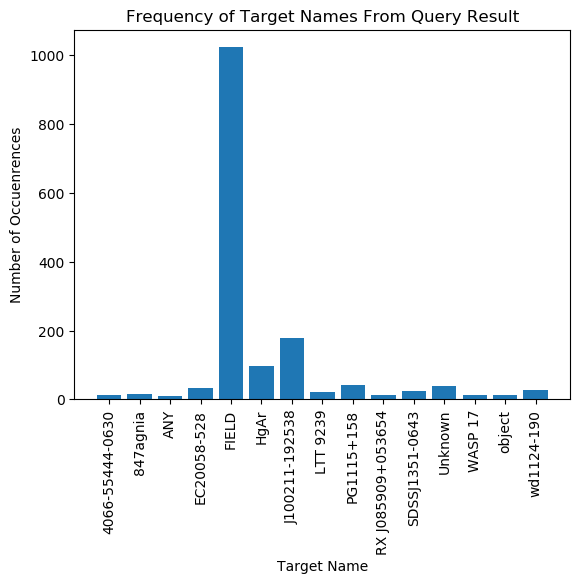

In [158]:
target_names, counts = np.unique(results['target_name'], return_counts=True)

# Remove all counts of less than 5 - otherwise too much data
mask = counts >=10
filtered_target_names = target_names[mask]
filtered_counts = counts[mask]

indices = np.arange(len(filtered_target_names))
plt.bar(indices, filtered_counts)
plt.title('Frequency of Target Names From Query Result')
plt.ylabel('Number of Occuenrences')
plt.xlabel('Target Name')
plt.xticks(range(len(filtered_target_names)), labels=filtered_target_names, rotation='vertical');

So the most common target name by far is `FIELD`.

We can also save results from a query to a file. Now lets select the observation ID, instrumnent name, and image position bounds from the observation and plane data tables, where the instrument is the SCUBA-2 telescope.

In [178]:
query = "SELECT Observation.observationID, Observation.instrument_name, Plane.position_bounds " + \
    "FROM caom2.Plane AS Plane JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID " + \
    "WHERE Observation.instrument_name = 'SCUBA-2'"
cadc.run_query(query, 'sync', output_file='test_output_noauth.tsv', output_format='tsv')


Additionally, a table can be uploaded to the server to be used in a query

In [ ]:
upload_resource = 'data/votable.xml'
j = cadc.run_query("SELECT * FROM tap_upload.test_table_upload", 'sync', \
                  upload_resource=upload_resource, upload_table_name="test_table_upload")

print(j.get_results())


### Asyncronous query
 Asynchronous queries results at server side. The queries can be accessed any time. As with synchronous queries, the results can be saved in memory (default) or in a file.

In [52]:
query = "SELECT observationID, instrument_name, target_name FROM caom2.Observation AS Observation"
job = cadc.run_query(query, 'async', verbose=True)
print(job)

Launched query: 'SELECT observationID, instrument_name, target_name FROM caom2.Observation AS Observation'
303 See Other
[('Date', 'Thu, 09 May 2019 16:25:56 GMT'), ('Strict-Transport-Security', 'max-age=0'), ('Location', 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/tap//async/m9rkat6qbm6hw0bb'), ('Content-Length', '0'), ('Vary', 'Origin'), ('Connection', 'close'), ('Content-Type', 'text/plain')]
303 See Other
[('Date', 'Thu, 09 May 2019 16:25:56 GMT'), ('Strict-Transport-Security', 'max-age=0'), ('Location', 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/tap//async/m9rkat6qbm6hw0bb'), ('Content-Length', '0'), ('Vary', 'Origin'), ('Connection', 'close'), ('Content-Type', 'text/plain')]
job m9rkat6qbm6hw0bb, at: https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/tap//async/m9rkat6qbm6hw0bb


Exception: Not Found

In [53]:
async_result = cadc.query_name_async('M31') # Not actually async?

TypeError: query_name_async() got an unexpected keyword argument 'verbose'

In [51]:
async_result.get_results()['caomObservationURI', 'target_name', 'target_type']

caomObservationURI,target_name,target_type
object,bytes32,bytes32
caom:HSTHLA/hst_12106_06_wfc3_ir_f160w_02,M31-B16-F06-IR,
caom:HSTHLA/hst_12073_10_wfc3_ir_f160w_04,M31-B02-F10-IR,
caom:CFHT/548630,m31,
caom:CFHT/548631,m31,
caom:CFHT/876828,M31-N,
caom:CFHT/876828,M31-N,
caom:CFHT/876828,M31-N,
caom:CFHT/548629,m31,
caom:CFHT/548637,m31,


In [109]:
good_obs_ids = ['icnh03040', 'icnh05040', 'jdrw5p010', 'jdrw5pr2q', 'jdrw12010', 'jdm96j010', 'jdrw90010']


query = "SELECT * " + \
    "FROM caom2.Plane AS Plane JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID " + \
    "WHERE (Observation.observationID = 'jdrw5p010' AND Plane.calibrationLevel = 3)"
print(query)
job = cadc.run_query(query, 'sync')
results = job.get_results()
results

SELECT * FROM caom2.Plane AS Plane JOIN caom2.Observation AS Observation ON Plane.obsID = Observation.obsID WHERE (Observation.observationID = 'jdrw5p010' AND Plane.calibrationLevel = 3)


caomPlaneURI,caomPublisherID,calibrationLevel,provenance_keywords,provenance_inputs,metrics_sourceNumberDensity,metrics_background,metrics_backgroundStddev,metrics_fluxDensityLimit,metrics_magLimit,position_bounds,position_bounds_samples,position_bounds_size,position_resolution,position_sampleSize,position_dimension_naxis1,position_dimension_naxis2,obsID,planeID,productID,metaRelease,dataRelease,dataProductType,provenance_name,provenance_version,provenance_reference,provenance_producer,provenance_project,provenance_runID,provenance_lastExecuted,quality_flag,position_timeDependent,position_bounds_points,energy_bounds_samples,energy_bounds_lower,energy_bounds_upper,energy_bounds_width,energy_bounds_integrated,energy_dimension,energy_resolvingPower,energy_sampleSize,energy_freqWidth,energy_freqSampleSize,energy_restwav,time_bounds_samples,time_bounds_lower,time_bounds_upper,time_bounds_width,time_bounds_integrated,time_dimension,time_resolution,time_sampleSize,time_exposure,polarization_dimension,metaChecksum,accMetaChecksum,energy_emBand,energy_bounds [2],energy_bandpassName,energy_transition_species,energy_transition_transition,time_bounds [2],polarization_states,lastModified,caomObservationURI,sequenceNumber,proposal_keywords,target_standard,target_redshift,target_moving,target_keywords,targetPosition_equinox,targetPosition_coordinates_cval1,targetPosition_coordinates_cval2,telescope_geoLocationX,telescope_geoLocationY,telescope_geoLocationZ,telescope_keywords,instrument_keywords,environment_seeing,environment_humidity,environment_elevation,environment_tau,environment_wavelengthTau,environment_ambientTemp,environment_photometric,members,typeCode,metaChecksum_2,obsID_2,accMetaChecksum_2,collection,observationID,algorithm_name,type,intent,metaRelease_2,proposal_id,proposal_pi,proposal_project,proposal_title,target_name,target_type,targetPosition_coordsys,telescope_name,requirements_flag,instrument_name,lastModified_2,maxLastModified
,,,,,1 / deg2,Jy / pix,Jy / pix,Jy,,deg,deg,deg,arcsec,arcsec,,,,,,,,,,,,,,,,,,deg,m,m,m,m,m,,,m,Hz,Hz,m,m,d,d,d,d,,d,d,s,,,,,m,,,,d,,,,,,,,,,,deg,deg,,,,,,arcsec,,deg,,m,C,,,,,,,,,,,,,,,,,,,,,,,,
object,object,int32,object,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,int64,int64,bytes36,bytes36,bytes64,bytes23,bytes23,bytes128,bytes128,bytes32,bytes256,bytes128,bytes256,bytes64,bytes23,bytes16,int32,object,object,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,int64,float64,float64,float64,int64,object,object,bytes32,float64,bytes32,bytes32,bytes32,float64,bytes32,bytes23,object,int32,object,int32,float64,int32,object,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,int32,object,bytes1,object,bytes36,object,bytes32,bytes128,bytes32,bytes32,bytes32,bytes23,bytes128,bytes128,bytes32,bytes256,bytes32,bytes32,bytes16,bytes32,bytes16,bytes32,bytes23,bytes23
caom:HST/jdrw5p010/jdrw5p010-PRODUCT,ivo://cadc.nrc.ca/mirror/HST?jdrw5p010/jdrw5p010-PRODUCT,3,"CRDS_VER=7.2.6, 7.2.6, 44aa309|CSYS_VER=hstdp-2018.3a",caom:HST/jdrw5pr3q/jdrw5pr3q-CALIBRATED caom:HST/jdrw5pr5q/jdrw5pr5q-CALIBRATED,--,--,--,--,--,[116.81553300000006 60.979892999999855 116.93586199999991 60.97533200000005 116.92630599999995 60.91657099999974 116.80619699999984 60.92112300000026],[116.815533 60.979893 2.0 116.935862 60.975332 1.0 116.926306 60.916571 1.0 116.806197 60.921123 1.0 116.815533 60.979893 0.0],0.08308573244673942,--,--,--,--,00000000-0000-0000-8aec-602368a3b069,00000000-0000-0000-be3e-921f11515a7f,jdrw5p010-PRODUCT,2019-01-10T10:39:17.000,2019-01-11T05:09:51.000,image,CALACS,DrizzlePac 2.2.4,http://www.stsci.edu/hst/acs/,STScI,HST,hst_0684.pmap,2019-02-07T04:49:15.000,,0,[116.815533 60.979893 116.935862 60.975332 116.926306 60.916571 116.806197 60.921123],[[7.08e-07 9.59e-07]],7.08e-07,9.59e-07,2.51e-07,--,--,--,--,110826245412181.94,--,--,[[58493.43431045139

In [110]:
urls = cadc.get_data_urls(results)
print(urls)

['https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/jdrw5p010_drc.fits?RUNID=b4kpqox5xrat5ada',
 'https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/data/pub/MAST/HST/product/jdrw5p010_drz.fits?RUNID=b4kpqox5xrat5ada']

[From get_data_urls docs:

        The function uses the IVOA DataLink Service
        (http://www.ivoa.net/documents/DataLink/) implemented at the CADC.
        It works directly with the results produced by Cadc.query_region and
        Cadc.query_name but in principle it can work with other query
        results produced with the Cadc query as long as the results
        contain the 'caomPublisherID' column. This column is part of the
        caom2.Plane table.
]

1 results gives 2 urls -> Drizzled data from the pipeline have the suffix drz.fits, and additionally drc.fits for WFC CTE-corrected data

http://www.stsci.edu/hst/acs/documents/handbooks/currentDHB/acs_Ch23.html

type of data component
    • SCI (science image)
    • ERR (error image)
    • DQ (data quality image)
    • SAMP1 (number of sample)
    • TIME1 (exposure time)
    • EVENTS2 (photon event list)
    • GTI2 (good time interval)
    • WHT (weight image)
    • CTX (context image)

In [111]:
from astropy.io import fits

with fits.open(urls[0]) as hdu_file:
    hdu_file.info()
    image_data = hdu_file[1].data

Filename: /home/badune/.astropy/cache/download/py3/6307a17108765ccf8d77a6043bf6f1c0
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     781   ()      
  1  SCI           1 ImageHDU        77   (4217, 4245)   float32   
  2  WHT           1 ImageHDU        46   (4217, 4245)   float32   
  3  CTX           1 ImageHDU        39   (4217, 4245)   int32   
  4  HDRTAB        1 BinTableHDU    631   4R x 311C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, D, K, 4A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, 8A, 23A, D, D, D, D, K, K, K, 8A, K, 23A, 9A, 20A, K, 4A, K, D, K, K, K, K, 23A, D, D, D, D, K, K, 3A, 3A, 4A, 4A, L, D, D, D, 3A, 1A, K, D, D, D, 13A, 3A, 4A, 4A, 12A, 12A, 23A, 8A, 23A, 10A, 10A, D, D, 3A, 3A, 23A, 4A, 8A, 7A, 23A, D, K, D, 11A, 9A, 8A, D, D, L, 4A, 18A, 3A, K, 7A, 5A, 3A, D, 13A, 8A, 4A, 3A, L, K, L, K, L, K, K, D, D, D, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, 23A, L, 1A, 3A, 6A, D, 3A, 6A, K, D,

In [121]:
print('Min:', np.nanmin(image_data))
print('Max:', np.nanmax(image_data))
print('Mean:', np.nanmean(image_data))
print('Stdev:', np.nanstd(image_data))


Min: -0.19443862
Max: 382.21207
Mean: 0.019526638
Stdev: 0.98123103


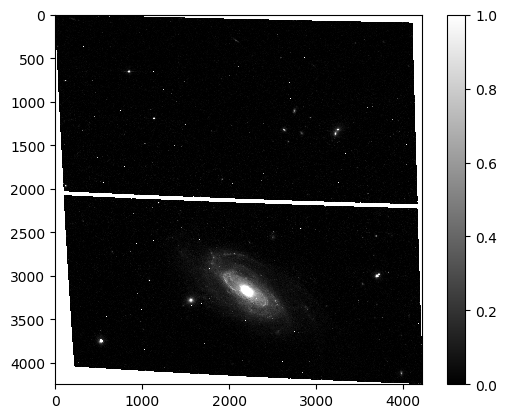

In [122]:
plt.imshow(image_data, vmin=0, vmax=1, cmap='gray')
plt.colorbar()
